This notebook deals with the microfading rawdata obtained when performing analyses with the microfading device from Fotonowy. It first describes the rawdata obtained and then provided python code to process them in order to obtain interim MFT data.

# Import statements 

In [3]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import colour
import scipy.interpolate as sip 

from scipy.optimize import curve_fit 

import process_rawdata

/home/gus/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Move to the rawdata folder 

In [1]:
cd ../data/raw/MFT

/home/gus/Documents/RCE/projects/2023-8005_FL_REL_MFT-Fotonowy/data/raw/MFT


# Rawdata description 

In [5]:
rawfiles = sorted(glob('*G03_07*'))
rawfiles

['noProject-BWS0001-BW1-G03_07-spect.txt',
 'noProject-BWS0001-BW1-G03_07-spect_convert.txt',
 'noProject-BWS0001-BW1-G03_07.rfc',
 'noProject-BWS0001-BW1-G03_07.txt']

Each microfading analyses performed with the Fotonowy device returns 4 files:
* a **.txt** file: contains the colorimetric info (dE equations + Lab) as a function of time and energy, as well as some metadata
* a **.rfc** file: contains the inital and final reflectance spectra
* a **-spect.txt** file: contains the raw signals (counts) recorded by the spectrometer (white, dark references and measurements on object) as a function of wavelengths
* a **-spect_convert.txt** file: same as the *-spect.txt* file but with a reduced wavelength range (380-780 nm)

The reflectance spectra between the first and last measurements are not provided. In order to retrieve them, one will need to calculate them using the raw signals provided in the *-spect.txt* and *-spect_convert.txt* files. 

In [10]:
txt_file = 'noProject-BWS0001-BW1-G03_07.txt'
txt_df = pd.read_csv(txt_file, sep='\t', skiprows = 8)

rfc_file = 'noProject-BWS0001-BW1-G03_07.rfc'
rfc_df = pd.read_csv(rfc_file, sep='\t', skiprows=2)

spect_file = 'noProject-BWS0001-BW1-G03_07-spect.txt'
spect_df = pd.read_csv(spect_file, sep='\t', skiprows=1)

spect_convert_file = 'noProject-BWS0001-BW1-G03_07-spect_convert.txt'
spect_convert_df = pd.read_csv(spect_convert_file, sep='\t', skiprows=1)

# Process rawdata 

 In the following cell, the microfading raw are being processed in order to obtain what we called 'interim data', based on standard file structure. The interim data are composed of two Pandas dataframes that can be saved as csv files: 
 
 1. **df_sp** : contains the reflectance spectra
 2. **df_cl** : contains the colorimetric data (LabCh, dE equations) according to time and energy values

In [12]:
# Import the rawdata files into two Pandas dataframes
raw_file_sp = 'noProject-BWS0001-BW1-G03_07-spect_convert.txt'
raw_df_sp = pd.read_csv(raw_file_sp, sep='\t', skiprows = 1)

raw_file_cl = 'noProject-BWS0001-BW1-G03_07.txt'
raw_df_cl = pd.read_csv(raw_file_cl, sep='\t', skiprows = 8)

# final wavelength range
wanted_wl = pd.Index(np.arange(410,751), name='wavelength_nm') 

# interpolated spectral counts values
df_counts_interpolated = pd.DataFrame(index=wanted_wl)

for col in raw_df_sp.columns:
    counts_interpolated = sip.interp1d(x=raw_df_sp.index, y=raw_df_sp[col])(wanted_wl)
    df_counts_interpolated[col] = counts_interpolated

# select white and dark spectral references (first and second columns respectively)
white_ref = df_counts_interpolated.iloc[:,0].values
dark_ref = df_counts_interpolated.iloc[:,1].values

# remove the white and dark ref
cols = df_counts_interpolated.columns
df_counts = df_counts_interpolated.iloc[:,2:-1]
df_counts.columns = cols[3:]
df_counts.index.name = 'wavelength_nm'

# define parameters for colorimetric calculations
D65 = colour.SDS_ILLUMINANTS["D65"]
d65 = colour.CCS_ILLUMINANTS["cie_2_1931"]["D65"]
cmfs = colour.colorimetry.MSDS_CMFS_STANDARD_OBSERVER["CIE 1931 2 Degree Standard Observer"]

# calculate the initial Lab values
counts_i = df_counts.iloc[:,0]
sp_i = counts_i.values/(white_ref)
sd_i = colour.SpectralDistribution(sp_i, wanted_wl)
XYZ_i = colour.sd_to_XYZ(sd_i, cmfs, illuminant=D65)
Lab_i = np.round(colour.XYZ_to_Lab(XYZ_i / 100, d65),2)

# final reflectance values
df_sp = pd.DataFrame(index=wanted_wl)
df_sp.index.name = 'wavelength_nm'

# empty list to store XYZ values
XYZ = []

# drop the before last column of df_counts
df_counts = df_counts.drop(df_counts.iloc[:,-2].name,axis=1)

# compute the reflectance, XYZ, and LabCh values
for col in df_counts.columns:  
    counts = df_counts[col].values
    sp = counts / white_ref
    sd = colour.SpectralDistribution(sp, wanted_wl)
    df_sp[col[15:]] = sp
    XYZ.append(colour.sd_to_XYZ(sd, cmfs, illuminant=D65))

XYZ = np.array(XYZ)

Lab = np.array([colour.XYZ_to_Lab(d / 100, d65) for d in XYZ])
LCh = np.array([colour.Lab_to_LCHab(d) for d in Lab])
    
L = []
a = []
b = []
C = []
h = []

[L.append(np.round(i[0],3)) for i in Lab]
[a.append(np.round(i[1],3)) for i in Lab]
[b.append(np.round(i[2],3)) for i in Lab]
[C.append(np.round(i[1],3)) for i in LCh]
[h.append(np.round(i[2],3)) for i in LCh]


# Compute the delta E values
dE76 = np.round(np.array([colour.delta_E(Lab[0], d, method="CIE 1976") for d in Lab]),3)
dE00 = np.round(np.array([colour.delta_E(Lab[0], d) for d in Lab]),3)

# Retrieve the times and energy values
times = [float(col[15:-3]) for col in df_counts.columns]
He = raw_df_cl['Watts']       # in MJ/m²
Hv = raw_df_cl['Lux'] * 1000  # in klxh


# interpolate colorimetric data
wanted_He = np.arange(0,He.values[-1], 0.1)

times = np.round(sip.interp1d(x=He, y= times)(wanted_He),2)
Hv = np.round(sip.interp1d(x=He, y= Hv)(wanted_He),2)
L = np.round(sip.interp1d(x=He, y= L)(wanted_He),2)
a = np.round(sip.interp1d(x=He, y= a)(wanted_He),2)
b = np.round(sip.interp1d(x=He, y= b)(wanted_He),2)
C = np.round(sip.interp1d(x=He, y= C)(wanted_He),2)
h = np.round(sip.interp1d(x=He, y= h)(wanted_He),2)
dE76 = np.round(sip.interp1d(x=He, y= dE76)(wanted_He),2)
dE00 = np.round(sip.interp1d(x=He, y= dE00)(wanted_He),2)


# Final colorimetric values
df_cl = pd.DataFrame({'time_s':times,'He_MJ/m2':wanted_He,'Hv_klxh':Hv, 'L*':L, 'a*':a, 'b*':b, 'C*':C, 'h':h, 'dE76':dE76, 'dE00':dE00})

df_sp.columns = He
df_sp = pd.DataFrame(data = np.round(sip.interp2d(df_sp.columns,pd.to_numeric(df_sp.index), df_sp)(wanted_He, wanted_wl),4),
                    index = wanted_wl,
                    columns = wanted_He,
                    )
df_sp.columns.name = 'He_MJ/m2'

# Visualizations 

## Counts and reflectance spectra 

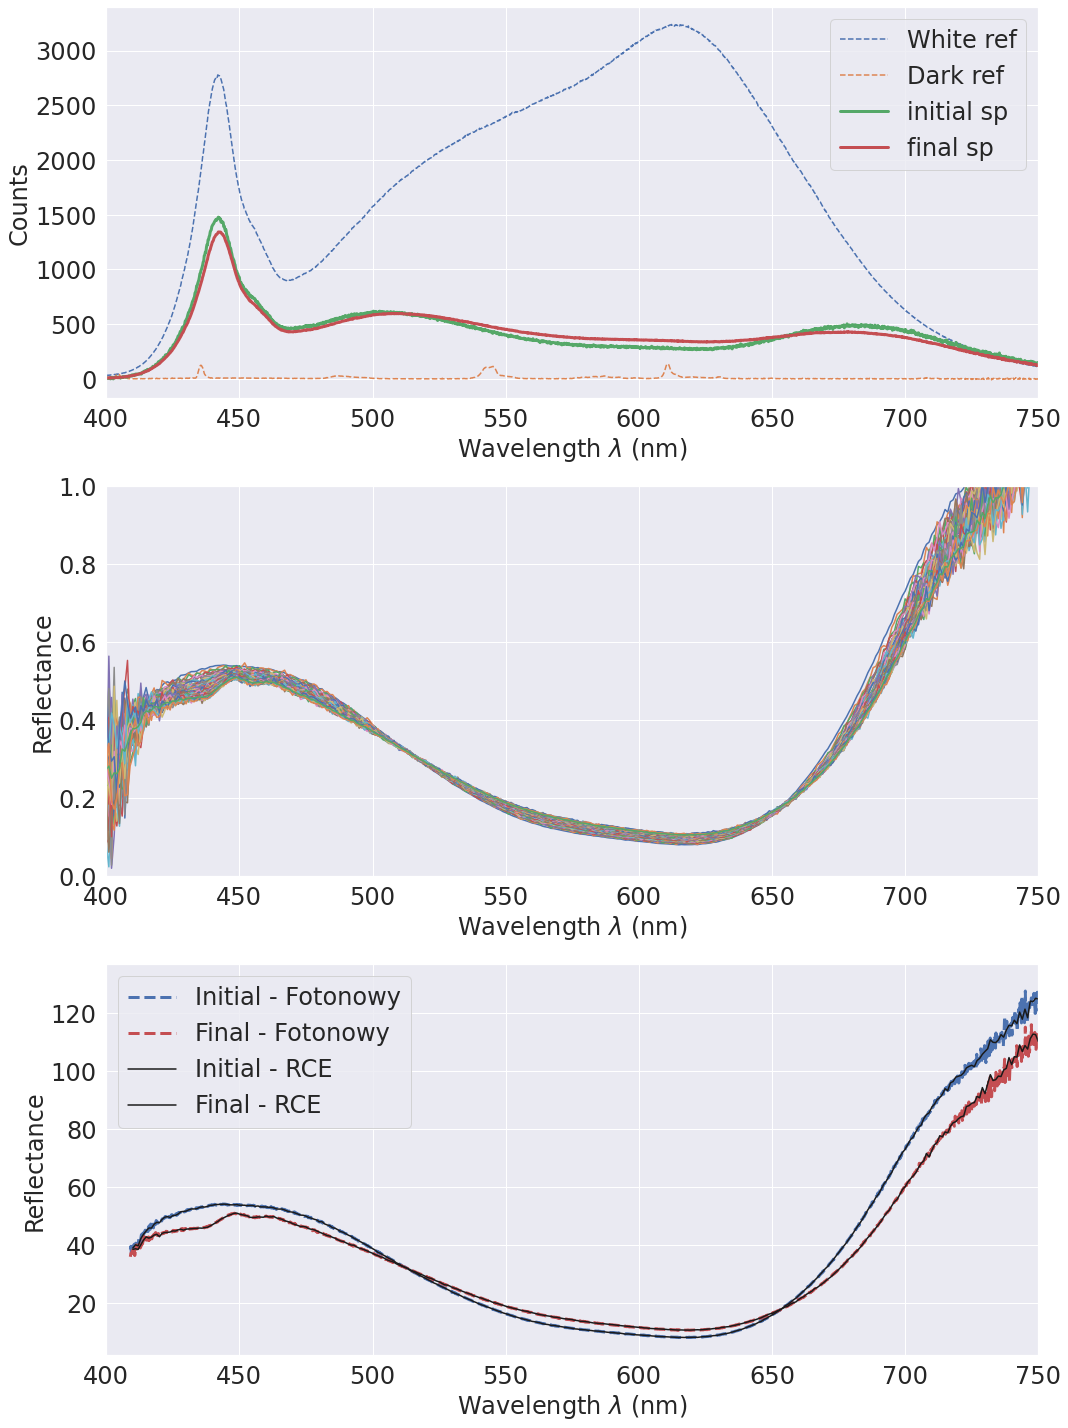

In [26]:

# Import the rawfile
rawfile = 'noProject-BWS0001-BW1-G03_07-spect_convert.txt'
df = pd.read_csv(rawfile, sep='\t', skiprows = 1)

wl = df.index

dark_ref = df['White Std. spectrum'].values
white_ref = df['#Wavelength [nm]'].values

sp1 = df['Sample spectrum8.849[s]']
sp2 = df['Sample spectrum609.196[s]']

sp_list = [sp1,sp2]
t_list = []
L_list = []
a_list = []
b_list = []
dE_list = []
wanted_wl = np.arange(400,750)
i = 2

sns.set()
fs = 24
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(15,20))

sp_i = df['Dark specetrum']
rs_i = sp_i.values/(white_ref)
rs_i = sip.interp1d(x=wl,y=rs_i)(wanted_wl)
sd_i = colour.SpectralDistribution(rs_i, wanted_wl)
D65 = colour.SDS_ILLUMINANTS["D65"]
d65 = colour.CCS_ILLUMINANTS["cie_2_1931"]["D65"]
cmfs = colour.colorimetry.MSDS_CMFS_STANDARD_OBSERVER["CIE 1931 2 Degree Standard Observer"]

XYZ_i = colour.sd_to_XYZ(sd_i, cmfs, illuminant=D65)
Lab_i = np.round(colour.XYZ_to_Lab(XYZ_i / 100, d65),2)


# Calculated Fotonowy data from the .rfc file

data_fy = rfc_df[(rfc_df['#Wavelength'] > 409) & (rfc_df['#Wavelength'] < 751)]

wl_fy = data_fy['#Wavelength']
sp_i_fy = data_fy['#Inital reflectance [%]']
sp_f_fy = data_fy['#Final reflectance [%]']



for col in df.columns[2:-1]:
    sp = df[col]
    
    rs = sp.values/(white_ref)
    rs_intp = sip.interp1d(x=wl,y=rs)(wanted_wl)
    
    sd = colour.SpectralDistribution(rs_intp, wanted_wl)
    D65 = colour.SDS_ILLUMINANTS["D65"]
    d65 = colour.CCS_ILLUMINANTS["cie_2_1931"]["D65"]
    cmfs = colour.colorimetry.MSDS_CMFS_STANDARD_OBSERVER["CIE 1931 2 Degree Standard Observer"]

    XYZ = colour.sd_to_XYZ(sd, cmfs, illuminant=D65)
    Lab = np.round(colour.XYZ_to_Lab(XYZ / 100, d65),2)
    
    dE = colour.delta_E(Lab_i, Lab)
    
    ax2.plot(wanted_wl,rs_intp)
    
    L_list.append(Lab[0])
    a_list.append(Lab[1])
    b_list.append(Lab[2])
    dE_list.append(dE)
    
    
    
    time = float(df.columns[i+1][15:-3])
    t_list.append(time)
    i = i+1
    
ax1.plot(wl, white_ref, ls='--', label='White ref')
ax1.plot(wl, dark_ref, ls='--', label='Dark ref')
ax1.plot(wl,sp1, lw=3, label='initial sp')
ax1.plot(wl,sp2, lw=3, label='final sp')

ax3.plot(wl_fy, sp_i_fy, ls='--', lw=3, color='b', label='Initial - Fotonowy')
ax3.plot(wl_fy, sp_f_fy, ls='--', lw=3, color='r', label='Final - Fotonowy')

ax3.plot(wl_rce, sp_i_rce, color='k', label='Initial - RCE')
ax3.plot(wl_rce, sp_f_rce, color='k', label='Final - RCE')

ax1.set_xlim(400,750)
ax2.set_xlim(400,750)
ax3.set_xlim(400,750)
ax2.set_ylim(0,1)

ax1.xaxis.set_tick_params(labelsize=fs)
ax2.xaxis.set_tick_params(labelsize=fs)
ax3.xaxis.set_tick_params(labelsize=fs)

ax1.yaxis.set_tick_params(labelsize=fs)
ax2.yaxis.set_tick_params(labelsize=fs)
ax3.yaxis.set_tick_params(labelsize=fs)

ax1.set_xlabel('Wavelength $\lambda$ (nm)', fontsize=fs)
ax2.set_xlabel('Wavelength $\lambda$ (nm)', fontsize=fs)
ax3.set_xlabel('Wavelength $\lambda$ (nm)', fontsize=fs)

ax1.set_ylabel('Counts', fontsize=fs)
ax2.set_ylabel('Reflectance', fontsize=fs)
ax3.set_ylabel('Reflectance', fontsize=fs)


ax1.legend(fontsize=fs)
ax3.legend(fontsize=fs)

plt.tight_layout()
plt.show()

## Colorimetric values 

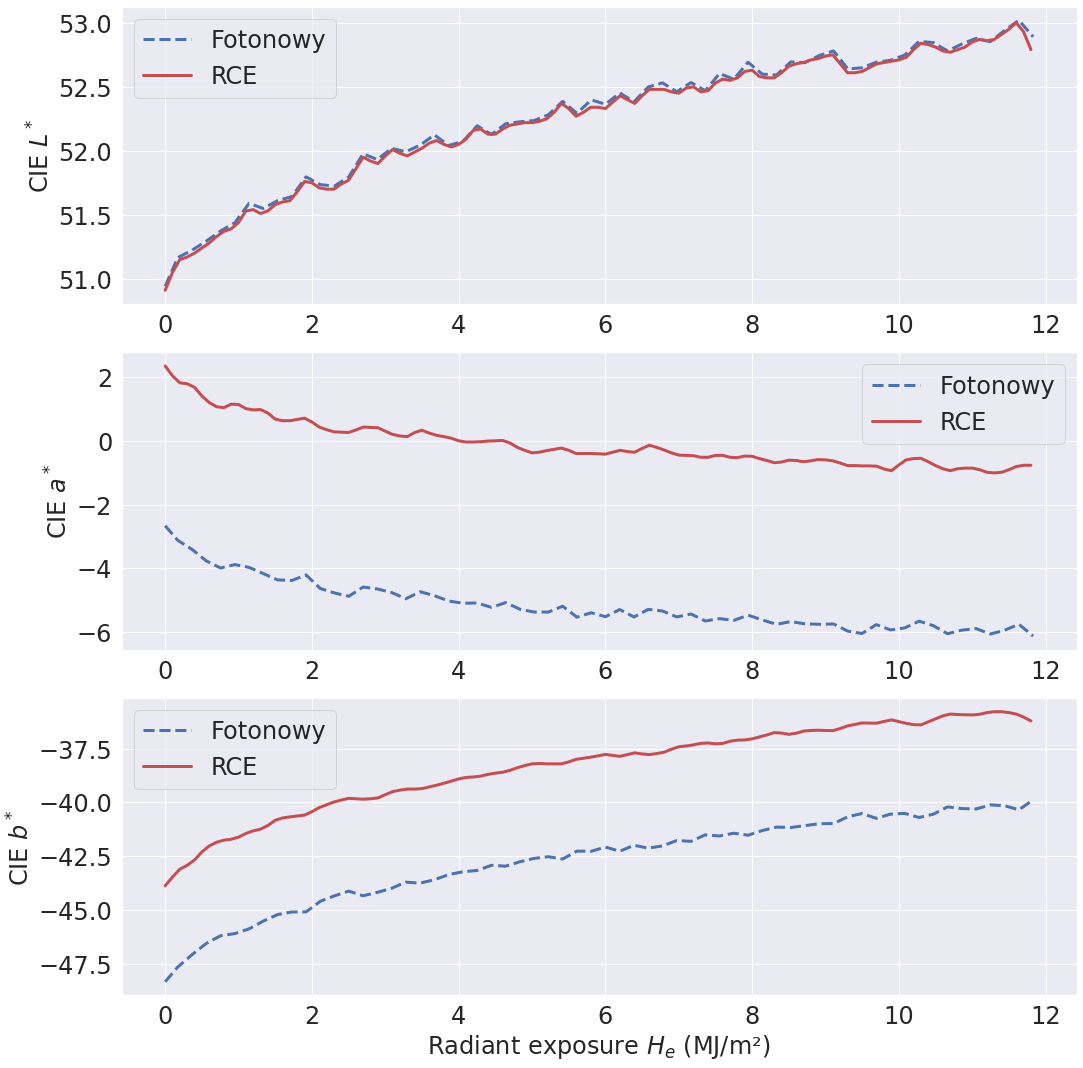

In [27]:
# Given Lab data from Fotonowy .txt file
Fy_He = raw_df_cl['Watts']
Fy_L = raw_df_cl['L']
Fy_a = raw_df_cl['a']
Fy_b = raw_df_cl['b']

wl_rce = df_sp.index


# Plots
sns.set()
fs = 24
fig2, [ax2,ax3,ax4] = plt.subplots(3,1, figsize=(15,15))



ax2.plot(Fy_He,Fy_L, ls='--', lw=3, color='b', label='Fotonowy')
ax3.plot(Fy_He,Fy_a, ls='--', lw=3, color='b', label='Fotonowy')
ax4.plot(Fy_He,Fy_b, ls='--', lw=3, color='b', label='Fotonowy')

ax2.plot(df_cl['He_MJ/m2'],df_cl['L*'], ls='-', lw=3, color='r', label='RCE')
ax3.plot(df_cl['He_MJ/m2'],df_cl['a*'], ls='-', lw=3, color='r', label='RCE')
ax4.plot(df_cl['He_MJ/m2'],df_cl['b*'], ls='-', lw=3, color='r', label='RCE')

ax1.set_xlabel('Wavelength $\lambda$ (nm)', fontsize=fs)
ax4.set_xlabel('Radiant exposure $H_e$ (MJ/m²)', fontsize=fs)

ax1.set_ylabel('Reflectance (%)', fontsize=fs)
ax2.set_ylabel('CIE $L^*$', fontsize=fs)
ax3.set_ylabel('CIE $a^*$', fontsize=fs)
ax4.set_ylabel('CIE $b^*$', fontsize=fs)

ax1.xaxis.set_tick_params(labelsize=fs)
ax2.xaxis.set_tick_params(labelsize=fs)
ax3.xaxis.set_tick_params(labelsize=fs)
ax4.xaxis.set_tick_params(labelsize=fs)

ax1.yaxis.set_tick_params(labelsize=fs)
ax2.yaxis.set_tick_params(labelsize=fs)
ax3.yaxis.set_tick_params(labelsize=fs)
ax4.yaxis.set_tick_params(labelsize=fs)


ax1.legend(fontsize=fs)
ax2.legend(fontsize=fs)
ax3.legend(fontsize=fs)
ax4.legend(fontsize=fs)

plt.tight_layout()
plt.show()

In [28]:
# Lab dataframe

cols = [('Initial SP','Fy txt'), ('Initial SP', 'Fy calc'), ('Initial SP', 'RCE'), ('Final SP','Fy txt'), ('Final SP', 'Fy calc'), ('Final SP', 'RCE')]

df_Lab = pd.DataFrame(columns=cols, index = ['L*','a*','b*'])
df_Lab.columns = pd.MultiIndex.from_tuples(df_Lab.columns)

df_Lab['Initial SP','Fy txt'] = Lab_i_fy_txt
df_Lab['Initial SP','Fy calc'] = Lab_i_fy
df_Lab['Initial SP','RCE'] = Lab_i
df_Lab['Final SP','Fy txt'] = Lab_f_fy_txt
df_Lab['Final SP','Fy calc'] = Lab_f_fy
df_Lab['Final SP','RCE'] = np.round(Lab[-1],2)

df_Lab

Initial SP                 Final SP               
       Fy txt Fy calc    RCE    Fy txt Fy calc    RCE
L*   50.94150   50.91  50.91  52.89050   52.75 -36.18
a*   -2.66028    2.36   2.23  -6.12634   -0.76 -36.18
b*  -48.32430  -43.87 -43.76 -39.88010  -36.28 -36.18

# Corrections

* In the **.txt** file, provide the $C^*$ and $h$ values so that people don't have to calculate them
* In the **.txt** file, change the columns name, *watts* -> *MJ/m²* and *lux* -> *Mlxh*, could maybe also add official symbols ($H_e$ and $H_v$)
* In the **-spect_convert.txt**, spelling mistake: *Dark specetrum* -> *Dark spectrum*

In [ ]:
x = wanted_He
y = dE00

c0 = 0.1
c1 = 1
c2 = 0.0001

# define models called f    
def fitting(x,c0,c1,c2):
    f = c0*(1/(1+(c1*np.exp(-c2*x)))) - (c0/c1)+1
    return f


def fitting2(x,c0,c1):
    f = c0*(1-np.exp(-c1*x))
    return f
    

    # find the best parameters for the model f
x_ext = np.arange(0,20,1)

c,cov = curve_fit(fitting,x,y,p0 = [c0,c1,c2])
y_ext = fitting(x_ext,c[0],c[1],c[2])

#c2,cov2 = curve_fit(fitting2,x,y,p0 = [c0,c1])
#y_ext2 = fitting2(x_ext,c[0],c[1])

plt.plot(wanted_He, y, label='measured')
plt.plot(x_ext,y_ext, label='fitted')
#plt.plot(x_ext,y_ext2, label='fitted2')

plt.legend()